In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras.models import load_model
from art.attacks.evasion import FastGradientMethod
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from art.estimators.classification import KerasClassifier
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from art.defences.preprocessor import JpegCompression
from art.defences.trainer import AdversarialTrainer
from sklearn.metrics import accuracy_score

tf.compat.v1.disable_eager_execution()

In [5]:
# Se abre la carpeta que contiene los archivos a tratar
path = './malimg_paper_dataset_imgs/'
familias = ImageDataGenerator().flow_from_directory(directory=path, target_size=(64,64), batch_size=10000)

Found 9339 images belonging to 25 classes.


In [6]:
familias.class_indices

{'Adialer.C': 0,
 'Agent.FYI': 1,
 'Allaple.A': 2,
 'Allaple.L': 3,
 'Alueron.gen!J': 4,
 'Autorun.K': 5,
 'C2LOP.P': 6,
 'C2LOP.gen!g': 7,
 'Dialplatform.B': 8,
 'Dontovo.A': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'Lolyda.AA1': 12,
 'Lolyda.AA2': 13,
 'Lolyda.AA3': 14,
 'Lolyda.AT': 15,
 'Malex.gen!J': 16,
 'Obfuscator.AD': 17,
 'Rbot!gen': 18,
 'Skintrim.N': 19,
 'Swizzor.gen!E': 20,
 'Swizzor.gen!I': 21,
 'VB.AT': 22,
 'Wintrim.BX': 23,
 'Yuner.A': 24}

In [7]:
imgs, labels = next(familias)
imgs.shape

(9339, 64, 64, 3)

In [8]:
labels.shape

(9339, 25)

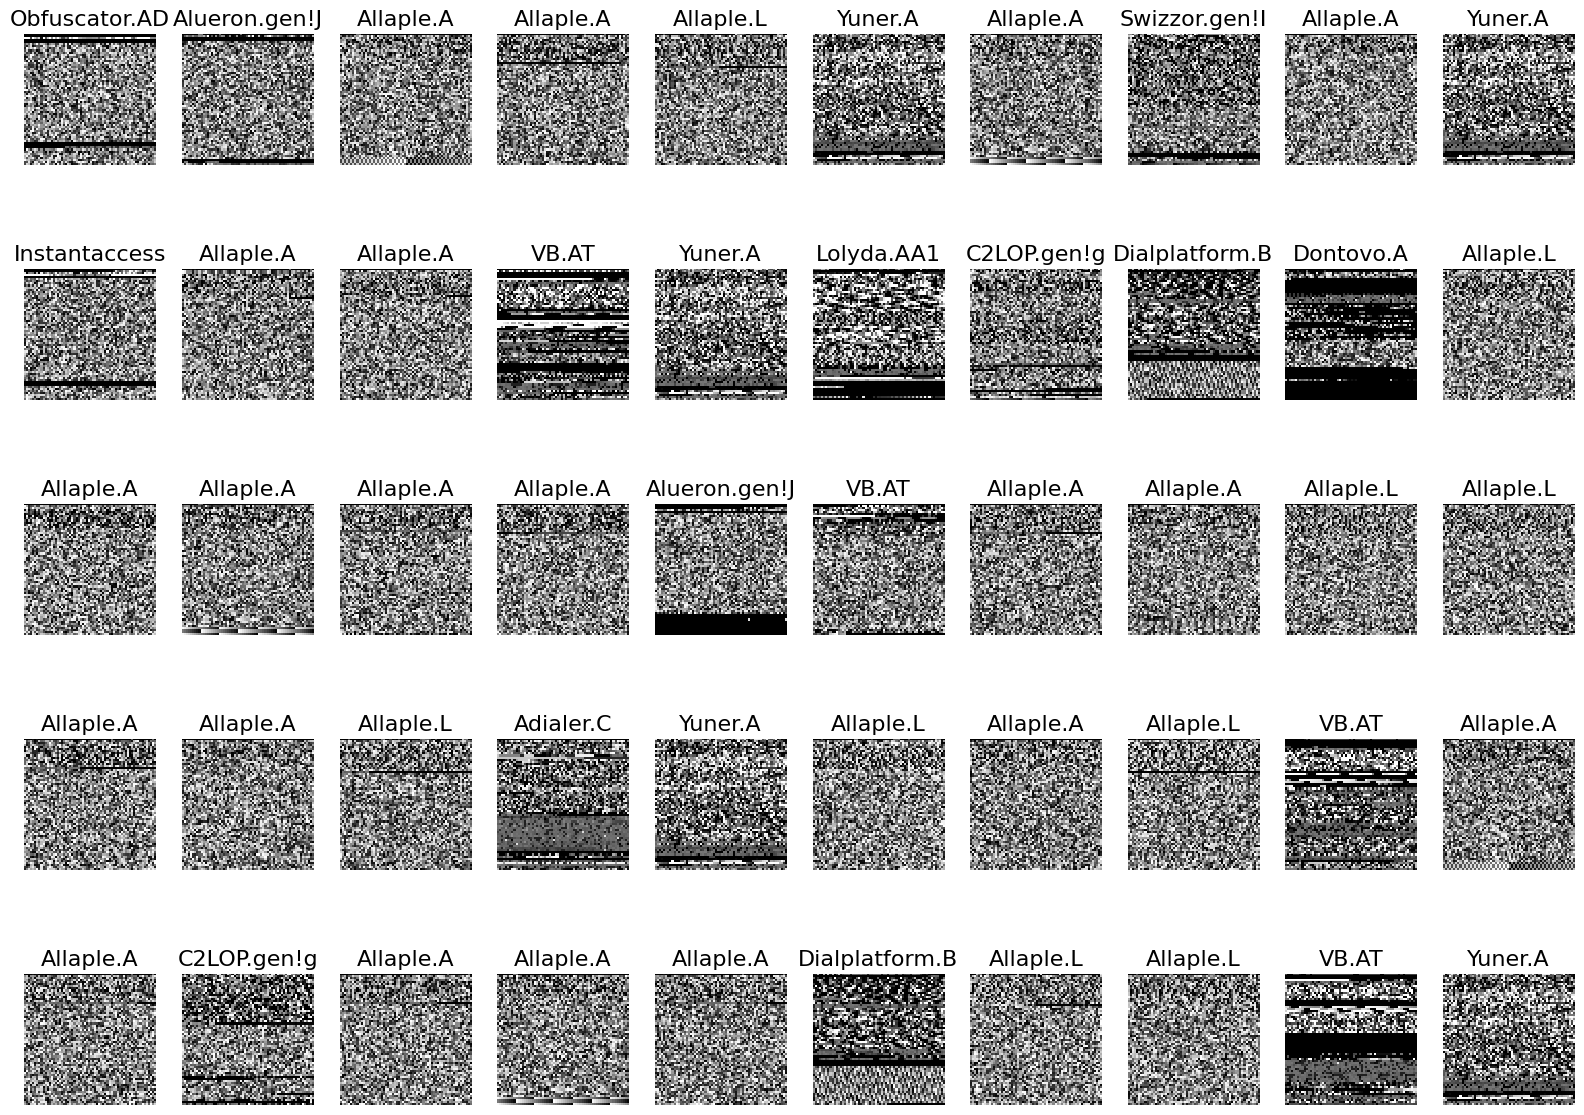

In [9]:
# Plots de imagenes con etiquetas
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(familias.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

plots(imgs, titles = labels)

In [10]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.3, random_state=42)

# Normalizar las imágenes
X_train = X_train / 255.0
X_test = X_test / 255.0

In [13]:
# Definir el modelo
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(25, activation='softmax')
])

In [14]:
# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Train on 6537 samples, validate on 2802 samples
Epoch 1/5
6537/6537 [==============================] - ETA: 0s - loss: 1.2566 - accuracy: 0.6078

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6537/6537 [==============================] - 55s 8ms/sample - loss: 1.2566 - accuracy: 0.6078 - val_loss: 0.6258 - val_accuracy: 0.7591
Epoch 2/5
6537/6537 [==============================] - 56s 9ms/sample - loss: 0.4214 - accuracy: 0.8772 - val_loss: 0.2905 - val_accuracy: 0.9111
Epoch 3/5
6537/6537 [==============================] - 52s 8ms/sample - loss: 0.2291 - accuracy: 0.9322 - val_loss: 0.2716 - val_accuracy: 0.9265
Epoch 4/5
6537/6537 [==============================] - 51s 8ms/sample - loss: 0.1623 - accuracy: 0.9481 - val_loss: 0.2083 - val_accuracy: 0.9422
Epoch 5/5
6537/6537 [==============================] - 51s 8ms/sample - loss: 0.1194 - accuracy: 0.9608 - val_loss: 0.1747 - val_accuracy: 0.9493


In [16]:
# Guardamos el modelo
model.save('malware_classifier_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
# Abrimos el modelo
tf.compat.v1.disable_eager_execution()
model = load_model('malware_classifier_model.h5')
classifier = KerasClassifier(model=model)

# Hacer predicciones en el conjunto de datos de prueba usando el modelo original
predictions_original = model.predict(X_test)
test_acc_original = np.mean(np.argmax(predictions_original, axis=1) == np.argmax(y_test, axis=1))
print('Test accuracy of original model:', test_acc_original)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Test accuracy of original model: 0.9625267665952891


## Ataque de envenenamiento

El ataque de envenenamiento, es como tal, modificar intencionadamente el conjunto de datos de entrenamiento del modelo introduciendo muestras maliciosas o adversarias. El objetivo es influir en el comportamiento del modelo durante el entrenamiento para que se vuelva menos confiable o incluso inútil en el entorno real. En este caso, veremos una disminución significativa en la precisión del modelo después del ataque de envenenamiento, lo que demuestra su efectividad para comprometer la integridad del modelo.

### Ataque

In [19]:
# Generar muestras de malware falsas para envenenar el conjunto de datos de entrenamiento
num_poisoned_samples = 100
poisoned_samples = np.random.rand(num_poisoned_samples, 64, 64, 3)
poisoned_labels = np.ones((num_poisoned_samples, 25))

# Agregar las muestras envenenadas al conjunto de datos de entrenamiento original
X_train_poisoned = np.concatenate((X_train, poisoned_samples), axis=0)
y_train_poisoned = np.concatenate((y_train, poisoned_labels), axis=0)

# Reentrenar el modelo con el conjunto de datos envenenado
classifier.fit(X_train_poisoned, y_train_poisoned, batch_size=32, nb_epochs=5)

In [20]:
# Hacer predicciones en el conjunto de datos de prueba usando el modelo envenenado
predictions_poisoned = classifier.predict(X_test)
test_acc_poisoned = np.mean(np.argmax(predictions_poisoned, axis=1) == np.argmax(y_test, axis=1))
print('Test accuracy of poisoned model:', test_acc_poisoned)

Test accuracy of poisoned model: 0.04425410421127766


### Defensa

In [21]:
# Aplicar una defensa contra envenenamiento (Jpeg Compression)
jpeg_compression = JpegCompression(clip_values=(0, 1), quality=50)
X_train_defended, y_train_defended = jpeg_compression(X_train_poisoned, y_train_poisoned)

# Reentrenar el modelo con el conjunto de datos defendido
classifier.fit(X_train_defended, y_train_defended, batch_size=32, nb_epochs=5)

In [22]:
# Evaluar el modelo defendido
predictions_defended = classifier.predict(X_test)
test_acc_defended = np.mean(np.argmax(predictions_defended, axis=1) == np.argmax(y_test, axis=1))
print('Test accuracy of defended model:', test_acc_defended)

Test accuracy of defended model: 0.32905067808708066


La defensa contra el envenenamiento se implementó utilizando una técnica de preprocesamiento, específicamente la compresión JPEG, que ayuda a eliminar las perturbaciones añadidas en las muestras envenenadas. Aunque la precisión del modelo defendido mejoró significativamente en comparación con el modelo envenenado (0.3290 frente a 0.04425), todavía está lejos de la precisión del modelo original (0.9625). Esto indica que, aunque la defensa ayudó a mitigar algunos efectos del envenenamiento, el conjunto de datos aún podría estar afectado por las muestras envenenadas. Es posible que se necesiten técnicas de defensa más robustas o una combinación de diferentes métodos para mejorar aún más la precisión.

## Método de Evasión

En este caso, el ataque de evasión implica modificar las entradas del modelo de manera sutil para engañarlo y producir resultados incorrectos. Acá, los resultados mostrarán una baja precisión en las muestras adversarias, lo que sugeriría que el modelo es vulnerable a manipulaciones en las entradas.

La presencia de vulnerabilidades a ataques de evasión enfatiza la necesidad de implementar técnicas de defensa robustas para proteger los modelos contra posibles manipulaciones adversariales. Esto incluye técnicas como la regularización, el entrenamiento adversarial y el monitoreo constante del rendimiento del modelo en presencia de entradas potencialmente maliciosas.

### Ataque

In [12]:
model = load_model('malware_classifier_model.h5')
classifier = KerasClassifier(model=model)

# Definir el ataque FGSM
attack = FastGradientMethod(estimator=classifier, eps=0.1)
# Generar adversarios para todo el conjunto de datos de prueba
X_test_adv = attack.generate(x=X_test)
predictions_adv = classifier.predict(X_test_adv)
accuracy_adv = accuracy_score(np.argmax(y_test, axis=1), np.argmax(predictions_adv, axis=1))

print('Accuracy on adversarial samples:', accuracy_adv)

Accuracy on adversarial samples: 0.02426837972876517


### Defensa

In [24]:
# Adversarial training for defense against evasion
# Crear un nuevo modelo
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(25, activation='softmax')
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Envolver el modelo con ART
classifier = KerasClassifier(model=model)

In [25]:
# Definir el ataque FGSM
attack = FastGradientMethod(estimator=classifier, eps=0.1)

# Crear el entrenador adversarial
adv_trainer = AdversarialTrainer(classifier, attacks=attack, ratio=1.0)

# Entrenar el modelo con adversarial training
adv_trainer.fit(X_train, y_train, nb_epochs=5, batch_size=32)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/5 [00:00<?, ?it/s]

In [26]:
# Evaluar el modelo en el conjunto de datos de prueba
predictions_adv_train = classifier.predict(X_test)
accuracy_adv_train = accuracy_score(np.argmax(y_test, axis=1), np.argmax(predictions_adv_train, axis=1))

print('Accuracy of model with adversarial training on clean samples:', accuracy_adv_train)

Accuracy of model with adversarial training on clean samples: 0.7230549607423269


In [27]:
# Evaluar el modelo en ejemplos adversariales
X_test_adv = attack.generate(x=X_test)
predictions_adv_test = classifier.predict(X_test_adv)
accuracy_adv_test = accuracy_score(np.argmax(y_test, axis=1), np.argmax(predictions_adv_test, axis=1))

print('Accuracy of model with adversarial training on adversarial samples:', accuracy_adv_test)

Accuracy of model with adversarial training on adversarial samples: 0.6820128479657388


Para defender el modelo contra ataques de evasión, utilizamos adversarial training, que entrena al modelo con ejemplos adversariales generados durante el proceso de entrenamiento. El modelo defendido mostró una precisión razonable en muestras limpias (0.7231) y una precisión decente en muestras adversariales (0.6820). Aunque estas precisiones son inferiores a la del modelo original en muestras limpias (0.9625), muestran que el modelo es más robusto frente a ejemplos adversariales en comparación con la precisión original de 0.0242 en muestras adversariales. Adversarial training claramente mejoró la resistencia del modelo a los ataques de evasión, aunque a costa de una menor precisión en datos limpios. Esto subraya la importancia de encontrar un equilibrio entre la precisión en datos limpios y la robustez contra ataques adversariales.